# Testing different Meta-Learning Algorithms and comparing them

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from functools import partial
import random



# Other dependencies
import time

import numpy as np
import matplotlib.pyplot as plt
#which tensorflow version?  
print(tf.__version__)
#is gpu available?
print(tf.config.list_physical_devices('GPU'))

2.17.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


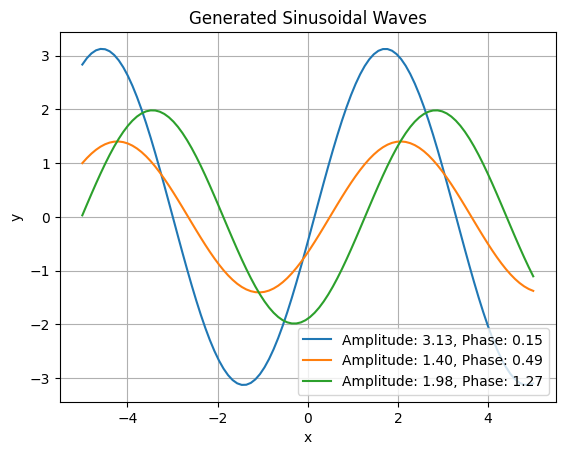

In [45]:

class SinusoidTask:
    """
    Represents a single sinusoidal task with customizable amplitude and phase.
    """
    def __init__(self, amplitude=None, phase=None):
        """
        Initializes a sinusoidal task with given or random amplitude and phase.

        Args:
            amplitude (float, optional): Amplitude of the sine wave. Random if None.
            phase (float, optional): Phase of the sine wave. Random if None.
        """
        self.amplitude = amplitude if amplitude is not None else np.random.uniform(0.1, 5.0)
        self.phase = phase if phase is not None else np.random.uniform(0, np.pi)

    def generate(self, x):
        """
        Computes sinusoidal values for given input x.

        Args:
            x (array-like): Input values.

        Returns:
            array: Output values of the sine wave.
        """
        return self.amplitude * np.sin(x - self.phase)

class SinusoidTaskDistribution:
    """
    Handles the creation of multiple sinusoidal tasks with varied amplitude and phase.
    """
    def __init__(self, amplitude_dist=None, phase_dist=None):
        """
        Initializes the task distribution with amplitude and phase distributions.

        Args:
            amplitude_dist (callable, optional): Distribution for amplitude. Defaults to uniform [0.1, 5.0].
            phase_dist (callable, optional): Distribution for phase. Defaults to uniform [0, pi].
        """
        self.amplitude_dist = amplitude_dist or partial(np.random.uniform, 0.1, 5.0)
        self.phase_dist = phase_dist or partial(np.random.uniform, 0, np.pi)

    def sample_task(self):
        """
        Samples a single sinusoidal task.

        Returns:
            SinusoidTask: A sinusoidal task with sampled amplitude and phase.
        """
        amplitude = self.amplitude_dist()
        phase = self.phase_dist()
        return SinusoidTask(amplitude, phase)

    def generate_batch(self, n_tasks, n_samples, x_range=(-5, 5), test_split=False):
        """
        Generates batches of sinusoidal tasks with random samples.

        Args:
            n_tasks (int): Number of tasks to sample.
            n_samples (int): Number of samples per task.
            x_range (tuple, optional): Range of input x values. Defaults to (-5, 5).
            test_split (bool, optional): Whether to generate separate test data.

        Returns:
            dict: Contains training (and optionally test) x and y data.
        """
        tasks = [self.sample_task() for _ in range(n_tasks)]

        x_train = np.random.uniform(x_range[0], x_range[1], (n_tasks, n_samples))
        y_train = np.array([task.generate(x) for task, x in zip(tasks, x_train)])

        result = {"x_train": x_train, "y_train": y_train}

        if test_split:
            x_test = np.random.uniform(x_range[0], x_range[1], (n_tasks, n_samples))
            y_test = np.array([task.generate(x) for task, x in zip(tasks, x_test)])
            result.update({"x_test": x_test, "y_test": y_test})

        return result# Demonstrating sinusoid task generation and visualization
def plot_sine_wave(x, y, label=None):
    """
    Helper function for plotting a sine wave.

    Args:
        x (array): Input x values.
        y (array): Output y values.
        label (str, optional): Legend label for the plot.
    """
    plt.plot(x, y, label=label)

plt.figure()
plt.title("Generated Sinusoidal Waves")
plt.xlabel("x")
plt.ylabel("y")

distribution = SinusoidTaskDistribution()

# Generate and plot 3 tasks
for _ in range(3):
    task = distribution.sample_task()
    x = np.linspace(-5, 5, 100)
    y = task.generate(x)
    plot_sine_wave(x, y, label=f"Amplitude: {task.amplitude:.2f}, Phase: {task.phase:.2f}")

plt.legend()
plt.grid(True)
plt.show()


SinusWaveGenerator generates sinusoidal waveforms with configurable amplitude and phase, supporting batch sampling and equally spaced data points for visualization or training.

The function equally_spaced_samples returns K equally spaced sinusoidal samples, ideal for creating smooth visualizations or evenly distributed data.

The loop demonstrates the generation and visualization of three sinusoidal waves with varying parameters.

In [46]:
def MakeDataSet(size_train=20000, test_size=10):
    """
    Generate a dataset of sinusoidal waves.

    Args:
        k (int): Number of samples per batch.
        size_train (int): Number of training samples.
        test_size (int): Number of test samples.

    Returns:
        tuple: Training and test datasets.
    """
    distribution = SinusoidTaskDistribution()
    train_data = [
        SinusoidTask(amplitude=distribution.amplitude_dist(), phase=distribution.phase_dist())
        for _ in range(size_train)
    ]
    test_data = [
        SinusoidTask(amplitude=distribution.amplitude_dist(), phase=distribution.phase_dist())
        for _ in range(test_size)
    ]
    return train_data, test_data

train_data, test_data = MakeDataSet()


The code over make training set and test set for a Neural network which is is going to be trained under after defining the model. 

The model under is what the is going to be trained. The regressor is a NN model with 2 hidden layers of size 40 with ReLU nonlinearties. 

In [47]:


class SineModel:
    def __init__(self, taskDistribution, lossfn='mse', outerLearningRate=0.001, innerLearningRate=0.01):
        """
        Initializes the SineModel for meta-learning.

        Args:
            taskDistribution: The task distribution to sample tasks from.
            lossfn: The loss function to use ('mse' or a custom function).
            outerLearningRate: Learning rate for outer-loop optimization.
            innerLearningRate: Learning rate for inner-loop optimization.
        """
        # Define the model architecture
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(40, activation='relu'),
            tf.keras.layers.Dense(40, activation='relu'),
            tf.keras.layers.Dense(1,)
        ])

        self.outerLearningRate = outerLearningRate
        self.innerLearningRate = innerLearningRate

        self.taskDistribution = taskDistribution
        self.lossfn = tf.keras.losses.MeanSquaredError() if lossfn == 'mse' else lossfn


    def fit(self, y, x, nSteps=1):
        """
        Perform a fixed number of gradient steps for task-specific adaptation.

        Args:
            y: Target outputs.
            x: Input data.
            nSteps: Number of inner-loop gradient steps.

        Returns:
            A cloned and adapted model.
        """
        clone = self.__deepCloneModel(self.model)  # Clone the model
        optimizer = tf.keras.optimizers.SGD(learning_rate=self.innerLearningRate)

        for _ in range(nSteps):
            with tf.GradientTape() as tape:
                loss = self.lossfn(tf.convert_to_tensor(y, dtype=tf.float32), clone(tf.convert_to_tensor(x, dtype=tf.float32)))  # Compute the loss
            gradients = tape.gradient(loss, clone.trainable_weights)  # Compute gradients
            optimizer.apply_gradients(zip(gradients, clone.trainable_weights))  # Apply gradients

        return clone



    def trainBatch(self, nSamples, nTasks, nBatch, alsoSampleTest=True):
        """
        Train the model over a batch of tasks.

        Args:
            nSamples: Number of samples per task.
            nTasks: Number of tasks in a batch.
            nBatch: Number of batches.
            alsoSampleTest: Whether to also sample a test set for evaluation.

        Returns:
            The average loss for the batch.
        """
        batch = self.taskDistribution.sampleTaskBatches(
            nSamples, nTasks, nBatch, alsoSampleTest=alsoSampleTest
        )

        return float(tf.reduce_mean(tf.map_fn(lambda batch: self.update(
            batch), elems=batch, fn_output_signature=tf.float32) / nTasks))

    def __deepCloneModel(self, model):
        """
        Clone the model, including its weights.

        Args:
            model: The model to clone.

        Returns:
            A cloned model with the same weights.
        """
        clone = tf.keras.models.clone_model(model)
        clone.set_weights(model.get_weights())
        return clone


In [48]:
# Loss function definition
def calculate_loss(pred_y, y):
    """Calculate the mean squared error between predictions and actual targets."""
    mse_loss = tf.keras.losses.MeanSquaredError()  # Instantiate the loss object
    return mse_loss(y, pred_y)  # Call the loss object with arguments

# Convert NumPy arrays to TensorFlow tensors
def convert_to_tensor(np_objects):
    """Convert NumPy arrays into TensorFlow tensors for processing."""
    return (tf.convert_to_tensor(obj) for obj in np_objects)

# Compute model loss and outputs
def evaluate_loss(model, x, y, loss_function=calculate_loss):
    """Evaluate the model's loss and return predictions."""
    logits = model(x)  # Directly call the model for predictions
    mse = loss_function(y, logits)
    return mse, logits




# Calculate gradients for model optimization
def calculate_gradients(model, x, y, loss_function=calculate_loss):
    """Calculate the gradients of the loss with respect to model parameters."""
    with tf.GradientTape() as tape:
        loss, _ = evaluate_loss(model.model, x, y, loss_function)  # Use model.model for forward pass
    gradients = tape.gradient(loss, model.model.trainable_variables)  # Compute gradients
    return gradients, loss



# Apply gradients to update model parameters
def update_parameters(optimizer, gradients, parameters):
    """Use computed gradients to adjust the model's parameters."""
    optimizer.apply_gradients(zip(gradients, parameters))

# Execute a single training step
def execute_training_step(x, y, model, optimizer):
    """Perform a training step on a single batch of data."""
    tensor_inputs, tensor_targets = convert_to_tensor((x, y))
    gradients, loss = calculate_gradients(model, tensor_inputs, tensor_targets)  # Pass the full model
    update_parameters(optimizer, gradients, model.model.trainable_variables)  # Use model.trainable_variables
    return loss



In [49]:
def train_model_over_epochs(dataset, pretrained_model=None, num_epochs=1, lr=0.001, log_interval=1000):
    """Train or fine-tune the model using the provided dataset for a specified number of epochs.

    Args:
        dataset: Dataset of tasks, each providing (x, y) pairs for training.
        pretrained_model: An optional pre-trained model for transfer learning.
        num_epochs: Number of epochs to train for.
        lr: Learning rate for training.
        log_interval: Interval at which to log progress.

    Returns:
        Trained model.
    """
    if pretrained_model:
        model = pretrained_model
    else:
        task_distribution = SinusoidTaskDistribution()  # Initialize a default task distribution
        model = SineModel(taskDistribution=task_distribution)

    optimizer = keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(num_epochs):
        loss_history = []
        cumulative_loss = 0.0
        epoch_start_time = time.time()

        for step, sinusoid_task in enumerate(dataset):
            # Generate training data from the task
            x = np.random.uniform(-5, 5, 50).reshape(-1, 1)  # Random x values for training
            y = sinusoid_task.generate(x.flatten())  # Corresponding y values

            # Perform a single training step
            loss = execute_training_step(x, y, model, optimizer)
            cumulative_loss += loss
            average_loss = cumulative_loss / (step + 1)
            loss_history.append(average_loss)

            if step % log_interval == 0 and step > 0:
                elapsed_time = time.time() - epoch_start_time
                print(f"Epoch {epoch + 1}, Step {step}: Average Loss = {average_loss:.4f}, "
                      f"Time for {log_interval} steps = {elapsed_time:.2f} seconds")
                epoch_start_time = time.time()

        # Plot the training loss curve for the epoch
        plt.plot(loss_history)
        plt.title(f"Epoch {epoch + 1}: Loss Progression")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.show()

    return model


Epoch 1, Step 1000: Average Loss = 3.4542, Time for 1000 steps = 47.66 seconds
Epoch 1, Step 2000: Average Loss = 3.3840, Time for 1000 steps = 50.67 seconds
Epoch 1, Step 3000: Average Loss = 3.3459, Time for 1000 steps = 55.27 seconds
Epoch 1, Step 4000: Average Loss = 3.2993, Time for 1000 steps = 52.80 seconds
Epoch 1, Step 5000: Average Loss = 3.2685, Time for 1000 steps = 50.72 seconds
Epoch 1, Step 6000: Average Loss = 3.2256, Time for 1000 steps = 52.66 seconds
Epoch 1, Step 7000: Average Loss = 3.2123, Time for 1000 steps = 46.03 seconds
Epoch 1, Step 8000: Average Loss = 3.2025, Time for 1000 steps = 41.01 seconds
Epoch 1, Step 9000: Average Loss = 3.1928, Time for 1000 steps = 39.38 seconds
Epoch 1, Step 10000: Average Loss = 3.1753, Time for 1000 steps = 39.20 seconds
Epoch 1, Step 11000: Average Loss = 3.1758, Time for 1000 steps = 43.30 seconds
Epoch 1, Step 12000: Average Loss = 3.1785, Time for 1000 steps = 43.22 seconds
Epoch 1, Step 13000: Average Loss = 3.1594, Time 

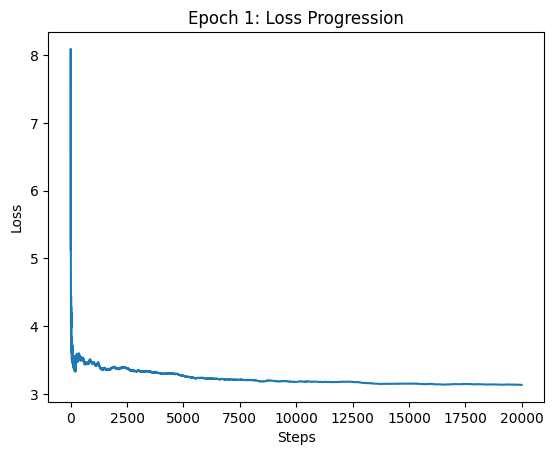

In [10]:
NN_model = train_model_over_epochs(train_data, num_epochs=1, lr=0.001, log_interval=1000)


In [50]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=15):
    """
    Compare model to average.
    
    Computes the mean of training sine wave actual y values and compares
    them to the model's prediction on a new sine wave. The intuition is
    that these two plots should be similar.

    Args:
        model: The model to evaluate.
        ds: Dataset of sinusoid tasks.
        model_name: Name of the model (for labeling the plot).
        K: Number of equally spaced samples for a new sine wave.
    """
    # Generate equally spaced samples for comparison
    x = np.linspace(-5, 5, K)  # Assuming the range [-5, 5]
    avg_pred = []

    for sinusoid_task in ds:
        y = sinusoid_task.generate(x)  
        avg_pred.append(y)

    
    avg_pred = np.mean(avg_pred, axis=0)  # Average over all tasks

    # Plot average prediction
    avg_plot, = plt.plot(x, avg_pred, '--', label='Average')

    # Calculate model prediction
    x_tensor = tf.convert_to_tensor(x.reshape(-1, 1), dtype=tf.float32)  # Reshape for model
    model_pred = model.model(x_tensor).numpy()  # Forward pass through the model
    model_plot, = plt.plot(x, model_pred, label=model_name)

    # Plot the results
    plt.legend()
    plt.title(f'Model Comparison: {model_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()


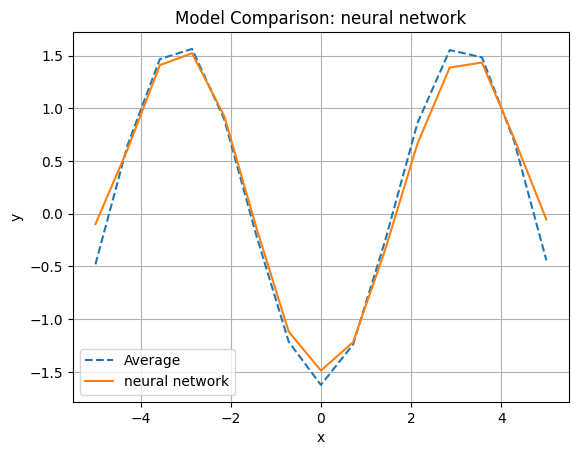

In [51]:
plot_model_comparison_to_average(NN_model, train_data)

Trying to see the difference between transfere learning and Meta learning

## Transfer Learning
Using the trainde model on several sinus wave on a new task. We therefor copy the model and then initialize it with it's weights. 


In [52]:
def eval_sine_test(model, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    """Evaluate how the model fits to a sine wave by training for specified steps.
    
    Args:
        model: Model to evaluate (can be Sequential or SineModel).
        x: Training data.
        y: Training targets.
        x_test: Test data.
        y_test: Test targets.
        num_steps: List of training steps to evaluate.
        
    Returns:
        A list containing step, predictions, and loss for each evaluation step.
    """
    fit_res = []
    tensor_x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
    tensor_y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Evaluate loss before any training
    if 0 in num_steps:
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)  # Directly call model
        fit_res.append((0, logits.numpy(), loss.numpy()))

    # Train for specified steps using copied_model
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    for step in range(1, max(num_steps) + 1):
        with tf.GradientTape() as tape:
            predictions = model(tf.convert_to_tensor(x, dtype=tf.float32))
            loss = tf.keras.losses.MeanSquaredError()(tf.convert_to_tensor(y, dtype=tf.float32), predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append((step, logits.numpy(), loss.numpy()))

    return fit_res


In [65]:
def eval_sinewave_for_test(model, sinusoid_task, num_steps=(0, 1, 10), lr=0.01, plot=True):
    """Evaluate the model's performance on a sine wave task.
    
    Args:
        model: Pre-trained model.
        sinusoid_task: A single sinusoid task.
        num_steps: List of training steps to evaluate.
        lr: Learning rate for fine-tuning.
        plot: Whether to plot the results.
        
    Returns:
        Fit results: A list of step, predictions, and loss for each evaluation step.
    """
    # Generate test data
    x_test = np.linspace(-5, 5, 100).reshape(-1, 1)
    y_test = sinusoid_task.generate(x_test.flatten())

    # Generate training data
    x_train = np.random.uniform(-5, 5, 10).reshape(-1, 1)
    y_train = sinusoid_task.generate(x_train.flatten())

    # Clone the model for evaluation
    copied_model = tf.keras.models.clone_model(model.model)
    copied_model.set_weights(model.model.get_weights())

    # Evaluate and train
    fit_res = eval_sine_test(copied_model, x_train, y_train, x_test, y_test, num_steps)

    # Plot results
    if plot:
        train, = plt.plot(x_train, y_train, '^', label='Training Points')
        ground_truth, = plt.plot(x_test, y_test, label='True Function')
        plots = [train, ground_truth]
        legend = ['Training Points', 'True Function']

        for step, logits, _ in fit_res:
            cur, = plt.plot(x_test, logits[:, 0], '--', label=f'After {step} Steps')
            plots.append(cur)
            legend.append(f'After {step} Steps')

        plt.legend()
        plt.ylim(-5, 5)
        plt.xlim(-6, 6)
        plt.title("Model Fine-tuning on New Sine Wave")
        plt.show()

    return fit_res


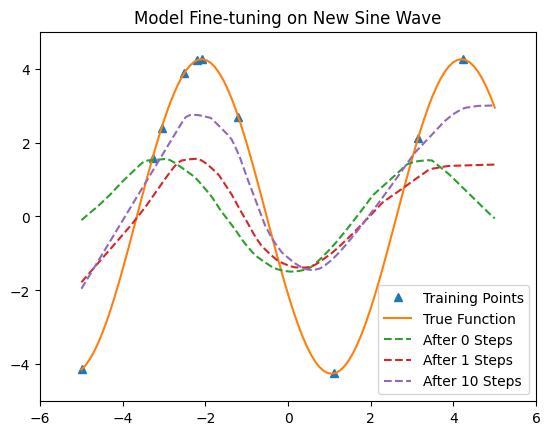

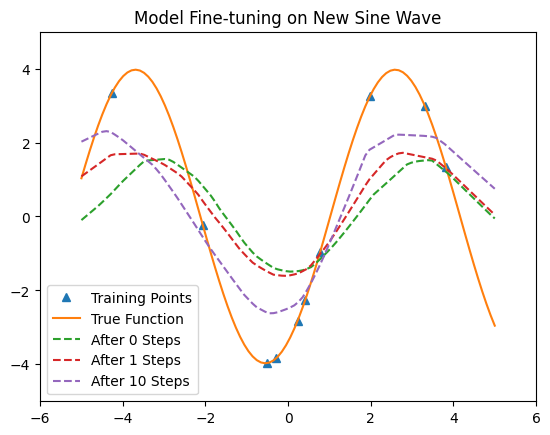

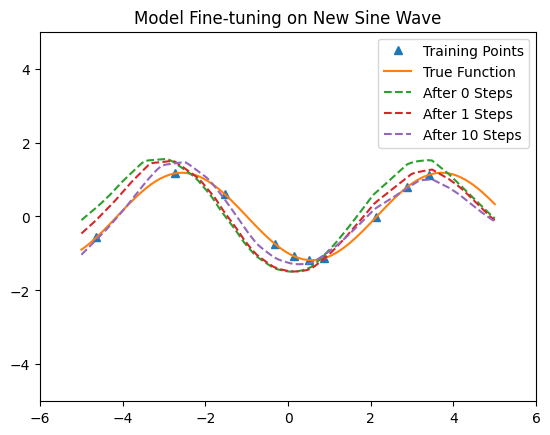

In [54]:
for index in np.random.randint(0, len(test_data), size=3):
    eval_sinewave_for_test(NN_model, test_data[index])



In [55]:
class FastWeights:
    def __init__(self, model, lr=0.01):
        """
        Implements an optimizer for applying SGD updates to weights of one neural net 
        based on gradients computed for another neural net. Allows for efficient 
        updates during inner-loop training in MAML.

        Args:
            model: The base neural network model.
            lr: Learning rate for inner-loop updates.
        """
        self.lr = lr
        self.model = model

    @tf.function
    def __call__(self, weights, input):
        """
        Performs a forward pass using the provided weights.

        Args:
            weights: List of updated weights for the model layers.
            input: Input tensor to pass through the model.

        Returns:
            The model's predictions using the updated weights.
        """
        output = tf.reshape(input, (-1, 1))
        for i, layer in enumerate(self.model.layers):
            kernel, bias = weights[i * 2], weights[i * 2 + 1]
            output = layer.activation(tf.matmul(output, kernel) + bias)
        return output

    @tf.function
    def computeUpdate(self, grads_and_vars):
        """
        Applies SGD updates to the provided weights.

        Args:
            grads_and_vars: List of tuples containing gradients and corresponding weights.

        Returns:
            Updated weights after applying the gradient descent step.
        """
        return [var - self.lr * grad for grad, var in grads_and_vars]


In [60]:

class MAML:
    def __init__(self, model, taskDistribution, outerLearningRate=0.001, innerLearningRate=0.01):
        """
        Implementation of MAML (Finn et al. 2017).

        Args:
            model: The base model (SineModel).
            taskDistribution: Task distribution for meta-learning.
            outerLearningRate: Learning rate for the meta-update step.
            innerLearningRate: Learning rate for task-specific adaptation.
        """
        self.model = model
        self.taskDistribution = taskDistribution
        self.outerLearningRate = outerLearningRate
        self.innerLearningRate = innerLearningRate
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=outerLearningRate)
        self.fastWeights = FastWeights(self.model.model, innerLearningRate)

    @tf.function
    def taskLoss(self, batch):
        """Computes the loss for one task given one batch of inputs and corresponding labels."""
        y_train, x_train, y_test, x_test = batch

        with tf.GradientTape() as taskTape:
            # Ensure x_train and x_test are properly reshaped
            x_train = tf.reshape(x_train, [-1, 1])  # Reshape if needed
            x_test = tf.reshape(x_test, [-1, 1])    # Reshape if needed
            
            # Compute train loss
            train_loss = self.model.lossfn(y_train, self.model.model(x_train))

        gradients = taskTape.gradient(train_loss, self.model.model.trainable_weights)
        updated_weights = self.fastWeights.computeUpdate(zip(gradients, self.model.model.trainable_weights))

        return self.model.lossfn(y_test, self.fastWeights(updated_weights, x_test))


    @tf.function
    def update(self, batch):
        """
        Meta-update step over a batch of tasks.

        Args:
            batch: Tuple (y_train, x_train, y_test, x_test) for multiple tasks.

        Returns:
            Meta-loss for the batch.
        """
        with tf.GradientTape() as metaTape:
            meta_loss = tf.reduce_mean(
                tf.map_fn(self.taskLoss, elems=batch, fn_output_signature=tf.float32)
            )
        meta_gradients = metaTape.gradient(meta_loss, self.model.model.trainable_weights)
        self.optimizer.apply_gradients(zip(meta_gradients, self.model.model.trainable_weights))
        return meta_loss


In [61]:
# Initialize SineModel with the task distribution
sine_model = SineModel(taskDistribution=None)

# Initialize MAML with SineModel
maml = MAML(
    model=sine_model,
    taskDistribution=None,  # You can set this to None since train_data is used
    outerLearningRate=0.001,
    innerLearningRate=0.01
)


Step 1000: Average Loss = 0.4105, Time for 1000 steps = 144.88 seconds
Step 2000: Average Loss = 0.2248, Time for 1000 steps = 134.96 seconds
Step 3000: Average Loss = 0.1557, Time for 1000 steps = 133.28 seconds
Step 4000: Average Loss = 0.1189, Time for 1000 steps = 123.99 seconds
Step 5000: Average Loss = 0.0956, Time for 1000 steps = 122.42 seconds
Step 6000: Average Loss = 0.0799, Time for 1000 steps = 120.86 seconds
Step 7000: Average Loss = 0.0687, Time for 1000 steps = 118.01 seconds
Step 8000: Average Loss = 0.0601, Time for 1000 steps = 130.77 seconds
Step 9000: Average Loss = 0.0535, Time for 1000 steps = 131.75 seconds
Step 10000: Average Loss = 0.0483, Time for 1000 steps = 132.62 seconds
Step 11000: Average Loss = 0.0439, Time for 1000 steps = 118.04 seconds
Step 12000: Average Loss = 0.0403, Time for 1000 steps = 118.47 seconds
Step 13000: Average Loss = 0.0372, Time for 1000 steps = 109.80 seconds
Step 14000: Average Loss = 0.0346, Time for 1000 steps = 98.94 seconds
St

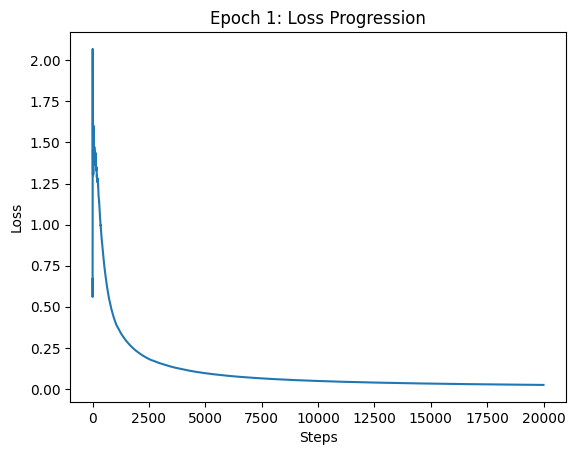

In [62]:
# Parameters for training
epochs = 1
lr_inner = 0.01  # Inner-loop learning rate
batch_size = 1   # Tasks per batch
log_steps = 1000

# Training Loop
for epoch in range(epochs):
    total_loss = 0
    losses = []
    start_time = time.time()

    for i, task in enumerate(random.sample(train_data, len(train_data))):
        # Use pre-generated tasks to generate data
        x_train = np.linspace(-5, 5, 10).reshape(-1, 1)  # Fixed 10 points for training
        y_train = task.generate(x_train.flatten())
        x_test = np.linspace(-5, 5, 10).reshape(-1, 1)  # Fixed 10 points for testing
        y_test = task.generate(x_test.flatten())

        
        # Prepare data and ensure correct shape
        x_train = tf.convert_to_tensor(np.linspace(-5, 5, 10).reshape(-1, 1), dtype=tf.float32)  # Shape: (10, 1)
        y_train = tf.convert_to_tensor(task.generate(x_train.numpy().flatten()), dtype=tf.float32)

        x_test = tf.convert_to_tensor(np.linspace(-5, 5, 10).reshape(-1, 1), dtype=tf.float32)  # Shape: (10, 1)
        y_test = tf.convert_to_tensor(task.generate(x_test.numpy().flatten()), dtype=tf.float32)

        # Perform MAML update
        batch = (y_train, x_train, y_test, x_test)
        meta_loss = maml.update(batch)

        # Logging and loss tracking
        total_loss += meta_loss.numpy()
        avg_loss = total_loss / (i + 1)
        losses.append(avg_loss)

        if (i + 1) % log_steps == 0:
            elapsed_time = time.time() - start_time
            print(f"Step {i + 1}: Average Loss = {avg_loss:.4f}, Time for {log_steps} steps = {elapsed_time:.2f} seconds")
            start_time = time.time()

    # Plot loss progression for the epoch
    plt.plot(losses)
    plt.title(f"Epoch {epoch + 1}: Loss Progression")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()


In [71]:
def eval_sinewave_for_test(maml_model, sinusoid_task, num_steps=(0, 1, 10), lr=0.01, plot=True):
    """Evaluate the MAML model's performance on a sine wave task.
    
    Args:
        maml_model: Trained MAML model wrapping the SineModel.
        sinusoid_task: A single sinusoid task.
        num_steps: List of training steps to evaluate.
        lr: Inner learning rate for task adaptation.
        plot: Whether to plot the results.
        
    Returns:
        Fit results: A list of tuples (step, predictions, loss) for each evaluation step.
    """
    # Generate test data
    x_test = np.linspace(-5, 5, 100).reshape(-1, 1)
    y_test = sinusoid_task.generate(x_test.flatten())

    # Generate training data
    x_train = np.random.uniform(-5, 5, 10).reshape(-1, 1)
    y_train = sinusoid_task.generate(x_train.flatten())

    # Convert to tensors
    x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Clone the inner model
    adapted_model = tf.keras.models.clone_model(maml_model.model.model)
    adapted_model.set_weights(maml_model.model.model.get_weights())  # Copy weights
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)  # Use SGD for task-specific updates

    fit_results = []

    for step in range(max(num_steps) + 1):
        # Compute predictions and loss on test data
        test_predictions = adapted_model(x_test_tensor).numpy()
        test_loss = maml_model.model.lossfn(y_test_tensor, tf.convert_to_tensor(test_predictions))

        # Log results if step matches
        if step in num_steps:
            fit_results.append((step, test_predictions, test_loss.numpy()))

        # Perform task-specific adaptation for the next step
        if step < max(num_steps):
            with tf.GradientTape() as tape:
                train_loss = maml_model.model.lossfn(y_train_tensor, adapted_model(x_train_tensor))
            gradients = tape.gradient(train_loss, adapted_model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, adapted_model.trainable_weights))

    # Plot results
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_test, y_test, label="True Function")
        plt.scatter(x_train, y_train, color="red", label="Training Points")
        for step, predictions, _ in fit_results:
            plt.plot(x_test, predictions, '--', label=f"Step {step}")
        plt.legend()
        plt.title("MAML Adaptation to New Sine Wave Task")
        plt.show()

    return fit_results


Evaluating Task 3


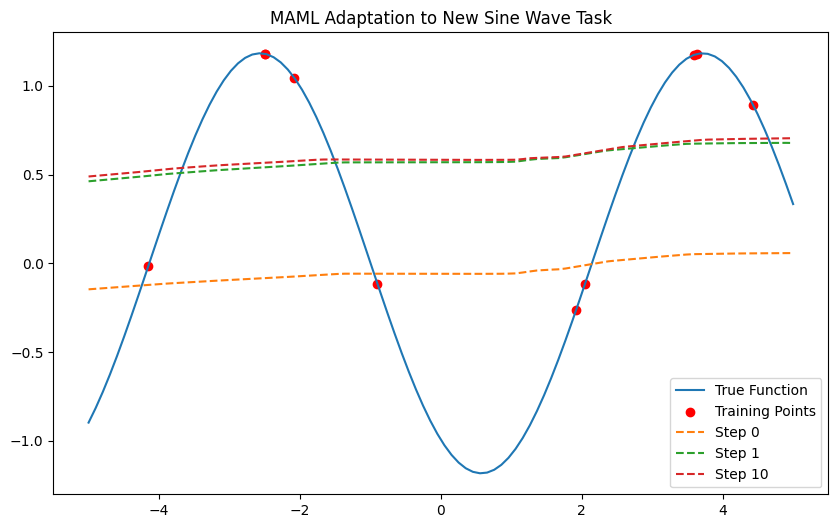

Evaluating Task 2


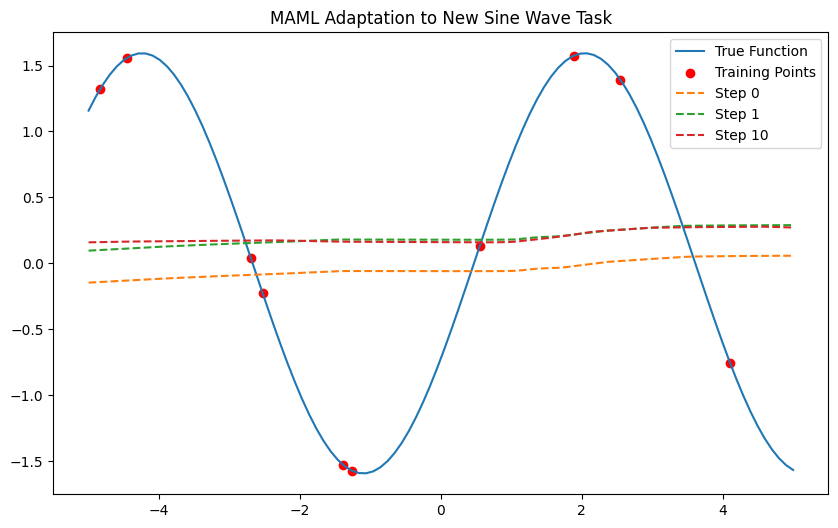

Evaluating Task 8


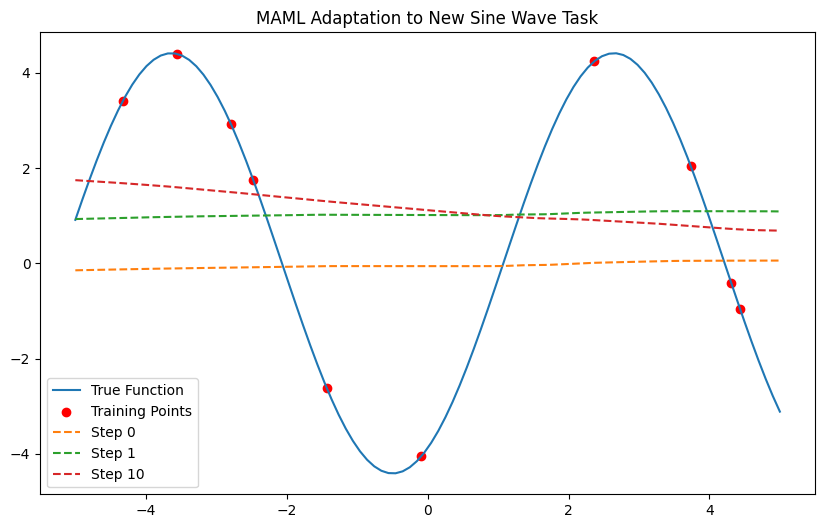

In [73]:
for index in np.random.randint(0, len(test_data), size=3):
    print(f"Evaluating Task {index + 1}")
    eval_sinewave_for_test(maml, test_data[index])
